In [19]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
import pandas as pd
from scipy import signal
from scipy.signal import butter, filtfilt, iirnotch, periodogram

In [20]:
import os
os.getcwd()

'c:\\Users\\aryan\\Documents\\GitHub\\ecz-ware\\training'

In [46]:
df_scratch = pd.read_csv('data\\emg_scratch.csv')
df_rest = pd.read_csv('data\\emg_rest.csv')
df_other = pd.read_csv('data\\emg_other.csv')
df_scratch

df_rest_400Hz = pd.read_csv('data\\400Hz\\emg_rest_400Hz.csv')

In [47]:
scratch_data = df_scratch['v2'].to_numpy()[0:1051]
other_data = df_other['v2'].to_numpy()[0:1051]
rest_data = df_rest['v2'].to_numpy()[0:1051]

rest_data_400Hz = df_rest_400Hz['v2'].to_numpy()

scratch_data_v = df_scratch['v2'].to_numpy()[1051:]
other_data_v = df_other['v2'].to_numpy()[1051:]
rest_data_v = df_rest['v2'].to_numpy()[1051:]

In [61]:
def normalize(data):
    data = data - np.mean(data)
    data = (data - data.min()) / (data.max() - data.min())
    return data

def bandpass_filter(data, lowcut=20.0, highcut=90.0, fs=200.0, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, data)

def find_noise_frequency(data, fs=200.0):
    f, Pxx = periodogram(data, fs=fs)
    idx = np.argmax(Pxx)
    return f[idx]

def adaptive_notch_filter(data, fs=200.0, quality=30):
    freq = find_noise_frequency(data, fs=fs)
    nyq = 0.5 * fs
    b, a = iirnotch(freq/nyq, quality)
    return filtfilt(b, a, data)

def cleanup(data):
    data = normalize(data)
    data = bandpass_filter(data)
    data = adaptive_notch_filter(data)
    return data

In [62]:
def stft(x, sampling_rate=200):
    f, t, spec = signal.stft(x.numpy(), fs=sampling_rate, nperseg=128, noverlap = 50, nfft=128)
    return tf.convert_to_tensor(np.abs(spec))

def stft_full(x, sampling_rate=200): # for visualization
    f, t, spec = signal.stft(x.numpy(), fs=sampling_rate, nperseg=128, noverlap = 50, nfft=128)
    return f, t, tf.convert_to_tensor(np.abs(spec))

def get_spectrogram(data: np.ndarray):
    # f, t, z = signal.stft(data, fs=200, nperseg=128, noverlap=50, nfft=128)
    spectrogram = tf.py_function(func=stft, inp=[data], Tout=tf.float32)
    # spectrogram.set_shape((129, 124))
    return spectrogram

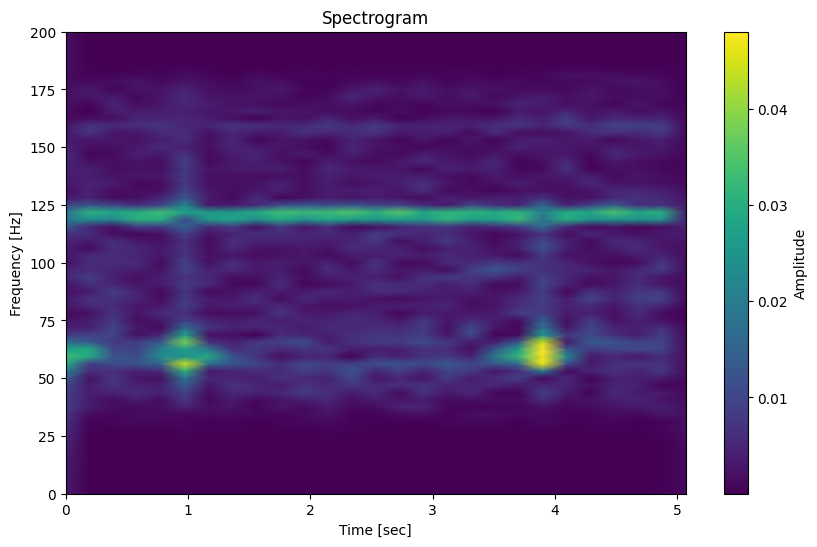

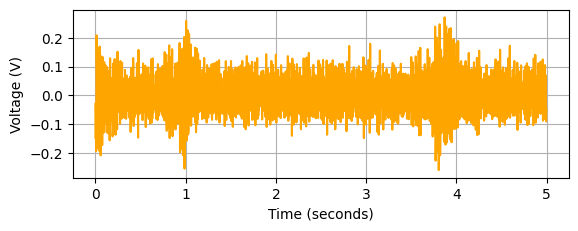

In [66]:
current_array = rest_data_400Hz[:]
# print(rest_data_400Hz.shape)
cleaned = cleanup(current_array)
cleaned = tf.convert_to_tensor(cleaned, dtype=tf.float32)
f, t, spec = stft_full(cleaned, sampling_rate=400)
s = get_spectrogram(cleaned)
# print(f, t)
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, s, shading='gouraud')
plt.title('Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Amplitude')  # limit frequency range to make plot clearer
plt.show()

time = np.arange(len(current_array)) / 400.0  

plt.subplot(2, 1, 2)
plt.plot(time, cleaned, label='Centered EMG Voltage', color='orange')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (seconds)')

plt.grid(True)

In [ ]:
# helper functions to train the model

def get_sample(data, start, sampling_rate=200):
    end = start + sampling_rate
    return data[start:end]

def get_data(filepath):
    df = pd.read_csv(filepath)
    return df[['v1', 'v2', 'label']].to_numpy()

def clean_data(data: numpy.ndarray):
    v1 = data[:, 0]
    v2 = data[:, 1]

    v1_cleaned = cleanup(v1)
    v2_cleaned = cleanup(v2)

    


array([[1.508, 1.633, 1.   ],
       [1.532, 1.742, 1.   ],
       [1.504, 1.654, 1.   ],
       ...,
       [1.519, 1.577, 1.   ],
       [1.478, 1.699, 1.   ],
       [1.548, 1.71 , 1.   ]])